In [29]:
import numpy as np
from numpy import matlib as mb
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
#os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

## Q1.2: Lucas-Kanade Tracking

Make sure to comment your code and use proper names for your variables. 

In [30]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
# from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
	
    # Initialize p to p0. Don't remove these lines.
    p = p0
    delta_p = np.ones((1,2))

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here:
    x1,y1,x2,y2=rect
    w,h=int(x2-x1),int(y2-y1)
    rbs0=RectBivariateSpline(np.arange(0,It.shape[0],1),np.arange(0,It.shape[1],1),It)
    rbs1=RectBivariateSpline(np.arange(0,It1.shape[0],1),np.arange(0,It1.shape[1],1),It1)
    change=1
    num_iters=int(num_iters)
    X,Y=np.mgrid[x1:x2+1:w*1j,y1:y2+1:h*1j]
    for ite in range(int(num_iters)):
        if change>threshold:
            px1=rbs1.ev(p[1]+Y,p[0]+X,dy=1).flatten()
            py1=rbs1.ev(p[1]+Y,p[0]+X,dx=1).flatten()
            A=np.zeros((w*h,2*w*h))
            for i in range(w*h):
                A[i,2*i],A[i,2*i+1]=px1[i],py1[i]
            delta_p,_,_,_=np.linalg.lstsq(np.matmul(A,mb.repmat(np.eye(2),w*h,1)),np.reshape(rbs0.ev(Y,X).flatten()-rbs1.ev(p[1]+Y,p[0]+X).flatten(),(w*h,1)),rcond=None)
            change=np.linalg.norm(delta_p)
            p=(p+delta_p.T).ravel()
        else:
            break
# ----------------------------------------------------------------------------------------------
    return p

### Debug Q1.2 

A few tips to debug your implementation:
- You can use the short snippet of code below to test if you get reasonable results. The snippet simply 
checks visualizes the resulting p from running LK on a single frame. You should be able to see a slight shift in the template. 

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

86 35


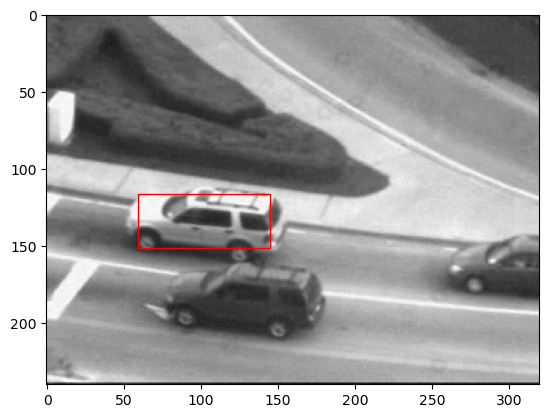

In [33]:
num_iters = 100
threshold = 0.01
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\carseq.npy")
rect = [59, 116, 145, 151]
It = seq[:,:,0]
w = rect[2] - rect[0]
h = rect[3] - rect[1]
print(w, h)

#Initial frame
plt.figure()
currentAxis = plt.gca()
rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
currentAxis.add_patch(rect_draw_It1)

# TODO: run LK and update template and plot 
# ----------------------------------------------------------------------------------------------
It1  = seq[:,:,1]
p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
rect = rect
rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')

currentAxis.add_patch(rect_draw_It1)
plt.imshow(It1, cmap='gray')
plt.show()
# ----------------------------------------------------------------------------------------------

## Q1.3: Track Sequence

In [5]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape

    rects =[rect]
    It = seq[:, :, 0]
        
    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest. Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        p =LucasKanade(seq[:,:,i-1],seq[:,:,i],rect, threshold, num_iters)
        rect = [rect[0]+p[0], rect[1]+p[1], rect[2]+p[0], rect[3]+p[1]]
        rects.append(rect)
    # ----------------------------------------------------------------------------------------------
        
    rects = np.array(rects)
    
    # Just a sanity check
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not {N}x{4}"
    return rects

### Q1.3: Track Car Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [6]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\carseq.npy")

# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(r"C:/Users/balub/OneDrive/Desktop/CV HW2/carseqrects.npy", rects)

100%|████████████████████████████████████████████████████████████████████████████████| 414/414 [01:14<00:00,  5.56it/s]


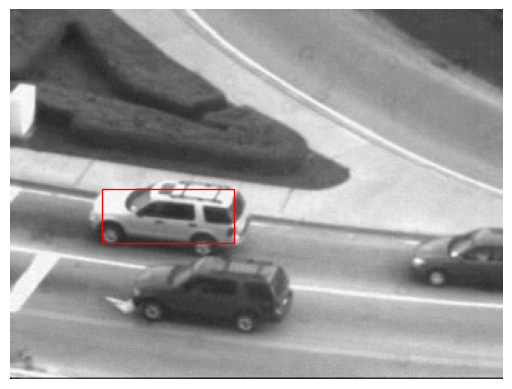

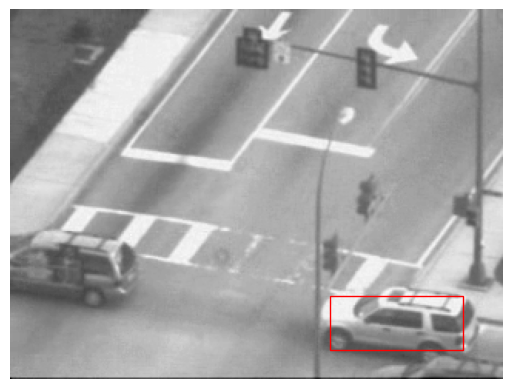

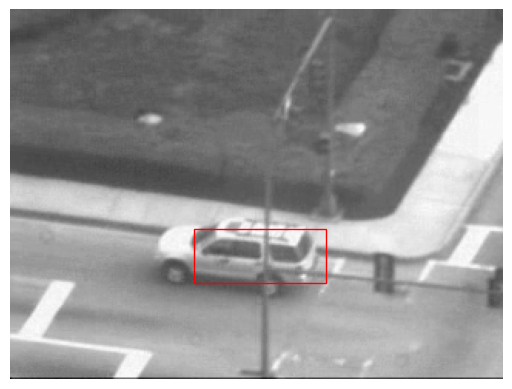

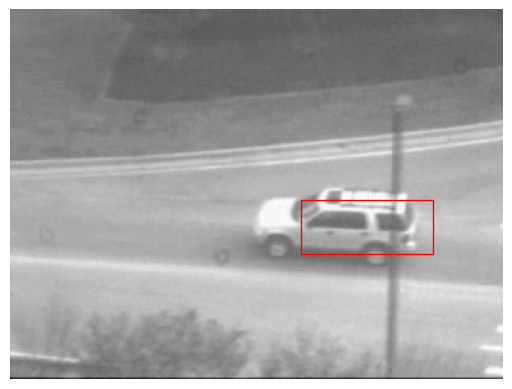

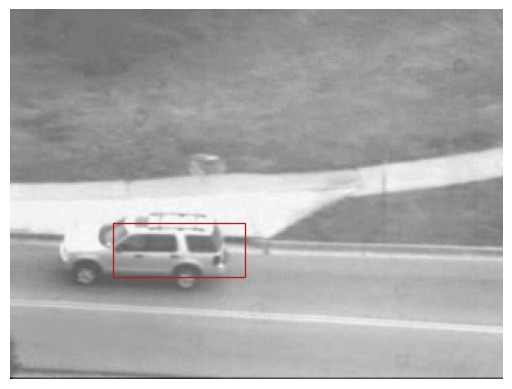

In [7]:
# # TODO: visualize. You can make this into a function to re-use it for other visualization questions. 
# # List of frames to save
frames_to_save = [1,80,160,280,410]

for idx in frames_to_save:
    # NOTE: here's an example on how to visualize a frame with its template. 
    frame = seq[:,:,idx-1]
    rect=rects[idx-1,:]
    w=rect[2]-rect[0]
    h = rect[3]-rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"C:/Users/balub/OneDrive/Desktop/CV HW2/carseq_images/sol_1.3_car_seq_{idx+1}.png")

### Q1.3: Test Girl Sequence

Same drill as with the car sequence. 

In [8]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(r"C:/Users/balub/OneDrive/Desktop/CV HW2/girlseqrects.npy", rects)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [02:28<00:00,  1.67s/it]


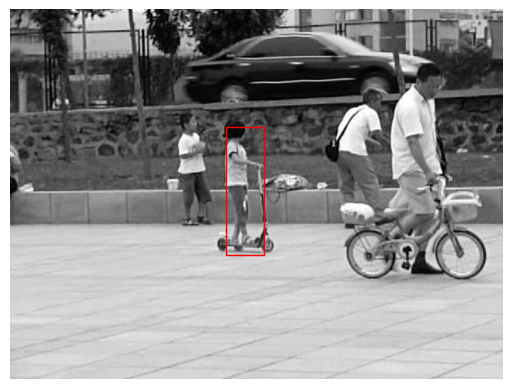

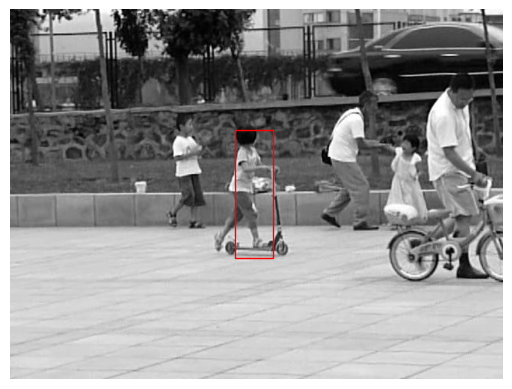

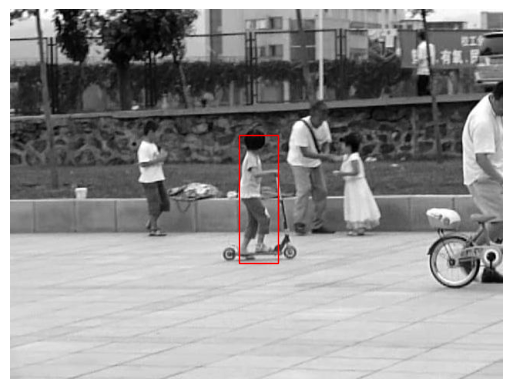

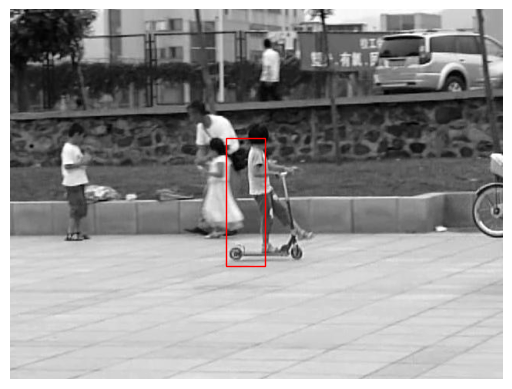

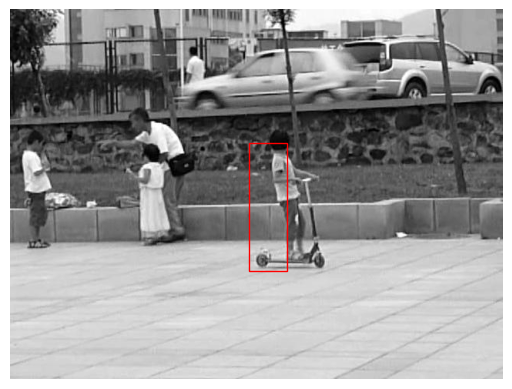

In [9]:
# TODO: visualize. You can copy-and-paste your visualization code from before (or re-use the function)
frames_to_save = [1,15,35,65,85]

for idx in frames_to_save:
    frame = seq[:,:,idx-1]
    rect=rects[idx-1,:]
    w = rect[2]-rect[0]
    h = rect[3]-rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"C:/Users/balub/OneDrive/Desktop/CV HW2/girlseq_images/sol_1.3_girlseq_{idx+1}.png")

## Q1.4: Tracking with Template Correction 

In [10]:
def TrackSequenceWithTemplateCorrection(seq, rect_0, num_iters, lk_threshold, drift_threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization
    :param[float] drift_threshold : float, threshold for the template update.

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape
    rect = np.copy(rect_0)
    rects_wtcr =[rect_0]
    p0 = np.zeros(2)
    It = seq[:,:,0]
    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest and do template correction.
    #  Add your code here:
    for frame in tqdm(range(N-1)):
        p=LucasKanade(It,seq[:,:,frame+1],rect,lk_threshold,num_iters,p0)
        p1=p+[rect[0]-rect_0[0],rect[1]-rect_0[1]]
        ps=LucasKanade(seq[:,:,0],seq[:,:,frame+1],rect_0,threshold,num_iters,p1)
        if np.linalg.norm(p1-ps)<threshold:
            p2=(ps-[rect[0]-rect_0[0],rect[1]-rect_0[1]])
            rect=[p2[0]+rect[0],p2[1]+rect[1],p2[0]+rect[2],p2[1]+rect[3]]
            p0=np.zeros(2)
            It=seq[:,:,frame+1]
            rects_wtcr.append(rect)
        else:
            rects_wtcr.append([rect[0]+p[0],rect[1]+p[1],rect[2]+p[0],rect[3]+p[1]])
            p0 = p
    # ----------------------------------------------------------------------------------------------  
    rects_wtcr = np.array(rects_wtcr)
    # Just a sanity check
    assert rects_wtcr.shape == (N, 4), f"Your output sequence {rects_wtcr.shape} is not {N}x{4}"
    return rects_wtcr

### Q1.4: Track Car Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [11]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\carseq.npy")

# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save(r"C:/Users/balub/OneDrive/Desktop/CV HW2/carseqrects-wtcr.npy", rects)

100%|████████████████████████████████████████████████████████████████████████████████| 414/414 [02:57<00:00,  2.34it/s]


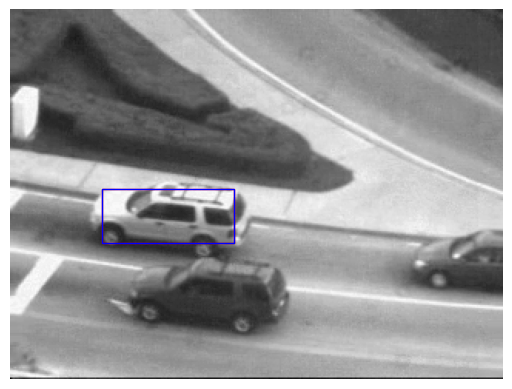

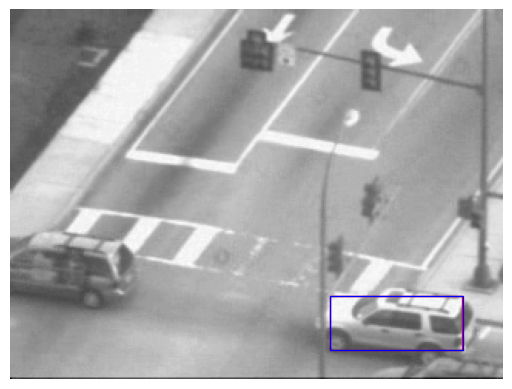

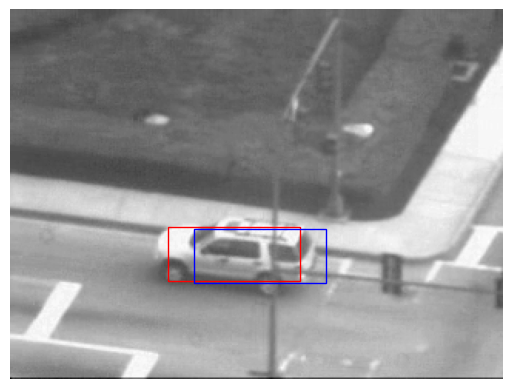

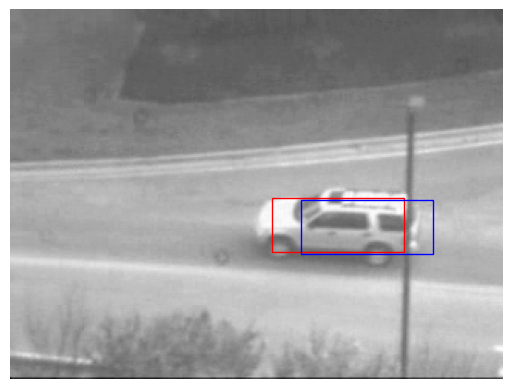

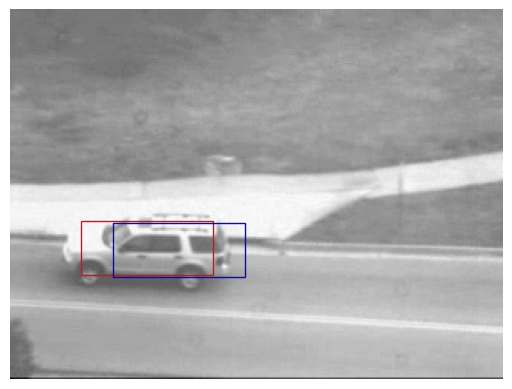

In [12]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save = [1,80,160,280,410]

rects_wtcr = np.load(r"C:/Users/balub/OneDrive/Desktop/CV HW2/carseqrects-wtcr.npy")
rects = np.load(r"C:/Users/balub/OneDrive/Desktop/CV HW2/carseqrects.npy")

for idx in frames_to_save:
    rect_wcrt = rects_wtcr[idx-1,:]
    rect = rects[idx-1,:]
    frame = seq[:,:,idx]

    plt.figure()
    currentAxis = plt.gca()
    rect_wcrt_draw = patches.Rectangle(
        (rect_wcrt[0], rect_wcrt[1]), rect_wcrt[2]-rect_wcrt[0],rect_wcrt[3]-rect_wcrt[1], linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), rect[2]-rect[0],rect[3]-rect[1], linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"C:/Users/balub/OneDrive/Desktop/CV HW2/carseq_images_wtcr/sol_1.4_carseq_{idx+1}.png")

### Q1.4: Track Girl Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [13]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save(r"C:/Users/balub/OneDrive/Desktop/CV HW2/girlseqrects-wtcr.npy", rects)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [16:04<00:00, 10.84s/it]


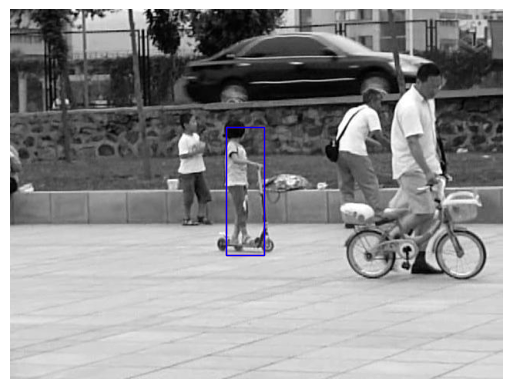

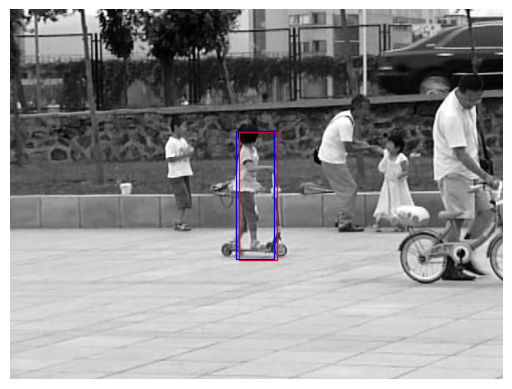

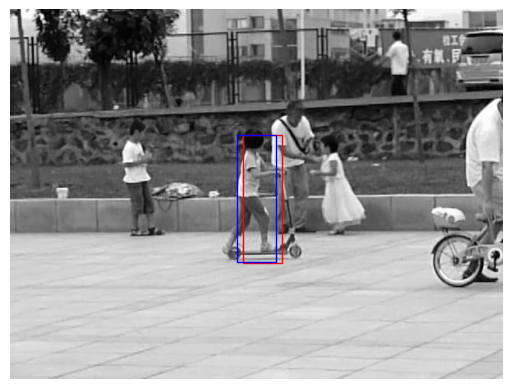

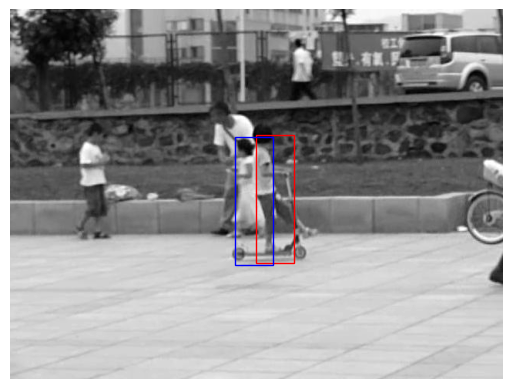

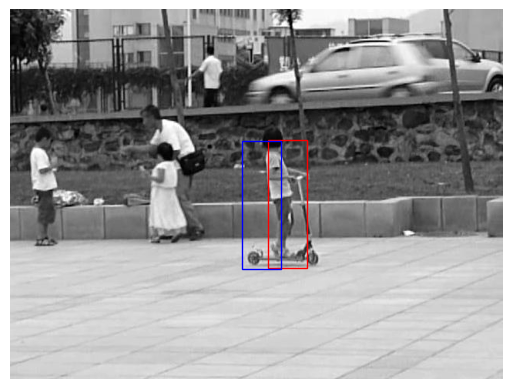

In [14]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save = [1,20,40,60,80]

rects_wtcr = np.load(r"C:/Users/balub/OneDrive/Desktop/CV HW2/girlseqrects-wtcr.npy")
rects = np.load(r"C:/Users/balub/OneDrive/Desktop/CV HW2/girlseqrects.npy")

for idx in frames_to_save:
    rect_wcrt = rects_wtcr[idx-1,:]
    rect = rects[idx-1,:]
    frame = seq[:,:,idx-1]

    plt.figure()
    currentAxis = plt.gca()
    rect_wcrt_draw = patches.Rectangle(
        (rect_wcrt[0], rect_wcrt[1]),rect_wcrt[2]-rect_wcrt[0],rect_wcrt[3]-rect_wcrt[1], linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]),rect[2]-rect[0],rect[3]-rect[1], linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"C:/Users/balub/OneDrive/Desktop/CV HW2/girlseq_images_wtcr/sol_1.4_girlseq_{idx+1}.png")